In [42]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

## 1. Create 2D IOR field
Input is an image where grey values map to IORs.

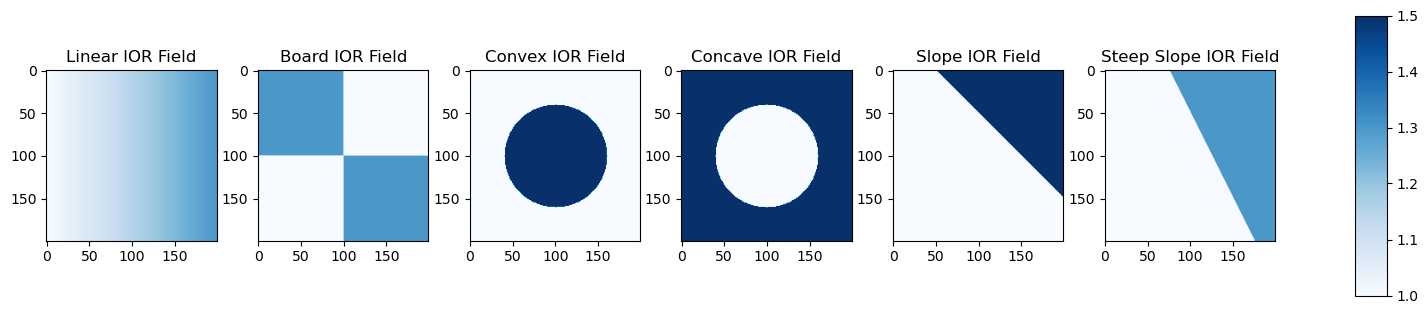

In [43]:
height, width = 200, 200
gradient = np.linspace(0, 0.3, width, dtype=np.float32)
linear_ior_field = np.tile(gradient, (height, 1)) + 1

tile_size = 100
board_ior_field = np.kron([[1, 0] * (width//tile_size//2),
                 [0, 1] * (width//tile_size//2)] * (height//tile_size//2),
                np.ones((tile_size, tile_size))) * 0.3 + 1.0

center = (height//2, width//2)
radius = 60
y, x = np.ogrid[:height, :width]
mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
convex_lens_ior_field = np.ones((height, width), dtype=np.float32)
convex_lens_ior_field[mask] = 1.5

concave_lens_ior_field = np.ones((height, width), dtype=np.float32) * 1.5
concave_lens_ior_field[mask] = 1.0


slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < x - 50:
            slope_ior_field[y, x] = 1.5
        else:
            slope_ior_field[y, x] = 1.0

steep_slope_ior_field = np.zeros((height, width), dtype=np.float32)
for y in range(height):
    for x in range(width):
        if y < 2 * x - 150:
            steep_slope_ior_field[y, x] = 1.3
        else:
            steep_slope_ior_field[y, x] = 1.0

plt.figure(figsize=(16, 4))

ior_fields = [linear_ior_field, board_ior_field, convex_lens_ior_field, concave_lens_ior_field, slope_ior_field, steep_slope_ior_field]
titles = ['Linear IOR Field', 'Board IOR Field', 'Convex IOR Field', 'Concave IOR Field', 'Slope IOR Field', 'Steep Slope IOR Field']

for i, field in enumerate(ior_fields, 1):
    plt.subplot(1, 6, i)
    plt.imshow(field, cmap='Blues', vmin=1.0, vmax=1.5)
    plt.title(titles[i - 1])

# Share the same colorbar
plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)

plt.show()

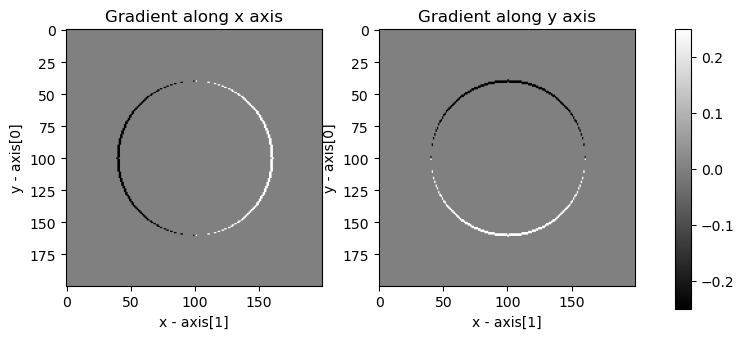

In [44]:
def compute_gradients(IOR):
    grad_x = np.gradient(IOR, axis=1)
    grad_y = np.gradient(IOR, axis=0)
    return grad_x, grad_y

grad_x, grad_y = compute_gradients(concave_lens_ior_field)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(grad_x, cmap='gray')
plt.title('Gradient along x axis')
plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.subplot(122)
plt.imshow(grad_y, cmap='gray')
plt.title('Gradient along y axis')

plt.xlabel('x - axis[1]')
plt.ylabel('y - axis[0]')

plt.tight_layout()
plt.subplots_adjust(right=0.8)
cbar_ax = plt.gcf().add_axes((0.85, 0.15, 0.02, 0.7))
plt.colorbar(cax=cbar_ax)
plt.show()

## 2. Update wavefront

In [45]:
field_size = 200
initial_wavefront_positions = [(0, i) for i in range(field_size)]  # initial positions are on the left edge
initial_wavefront_directions = [(1, 0) for _ in range(field_size)]  # initial directions are all to the right

num_steps = 1000
delta_t = 0.5
num_show_images = 5

ior_field_dict = {
    'linear': {'ior': linear_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'board': {'ior': board_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'convex_lens': {'ior': convex_lens_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'concave_lens': {'ior': concave_lens_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'slope': {'ior': slope_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None},
    'steep_slope': {'ior': steep_slope_ior_field, 'pos': [], 'dir': [], 'irradiance': None, 'dir_vec': None}
}

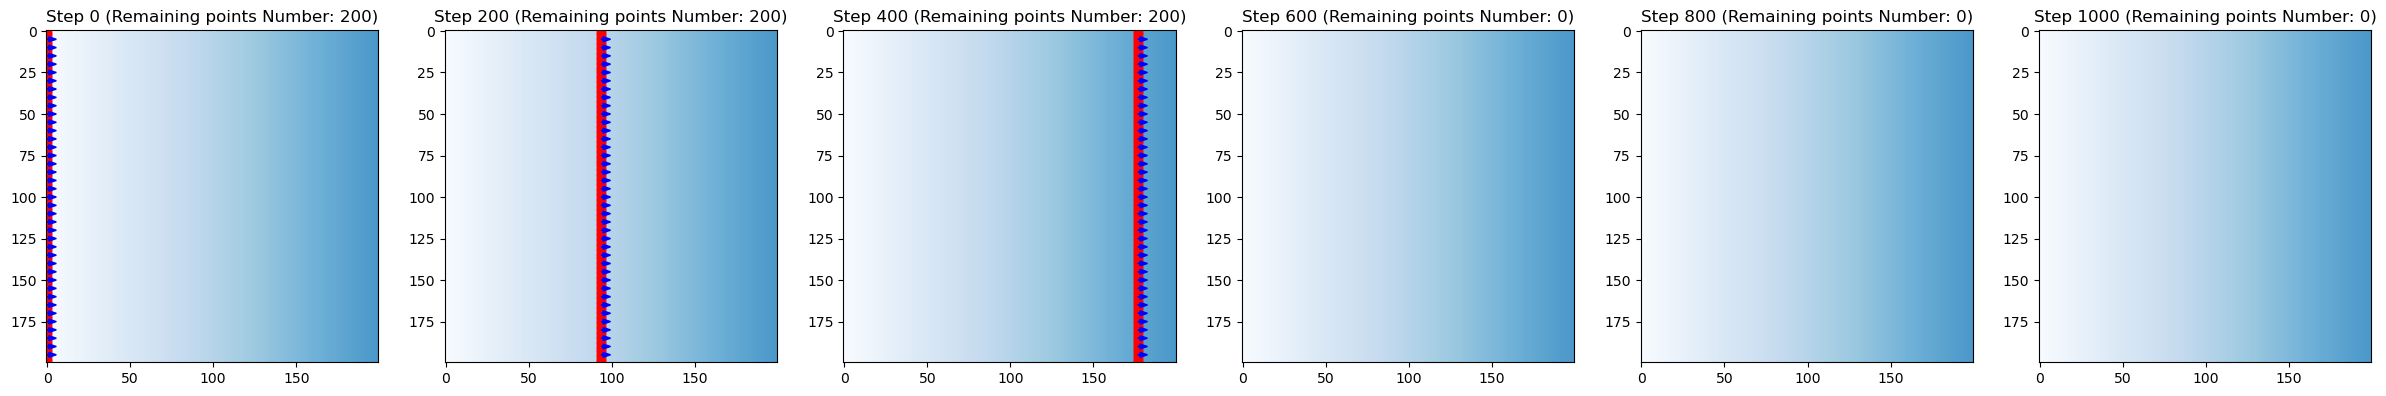

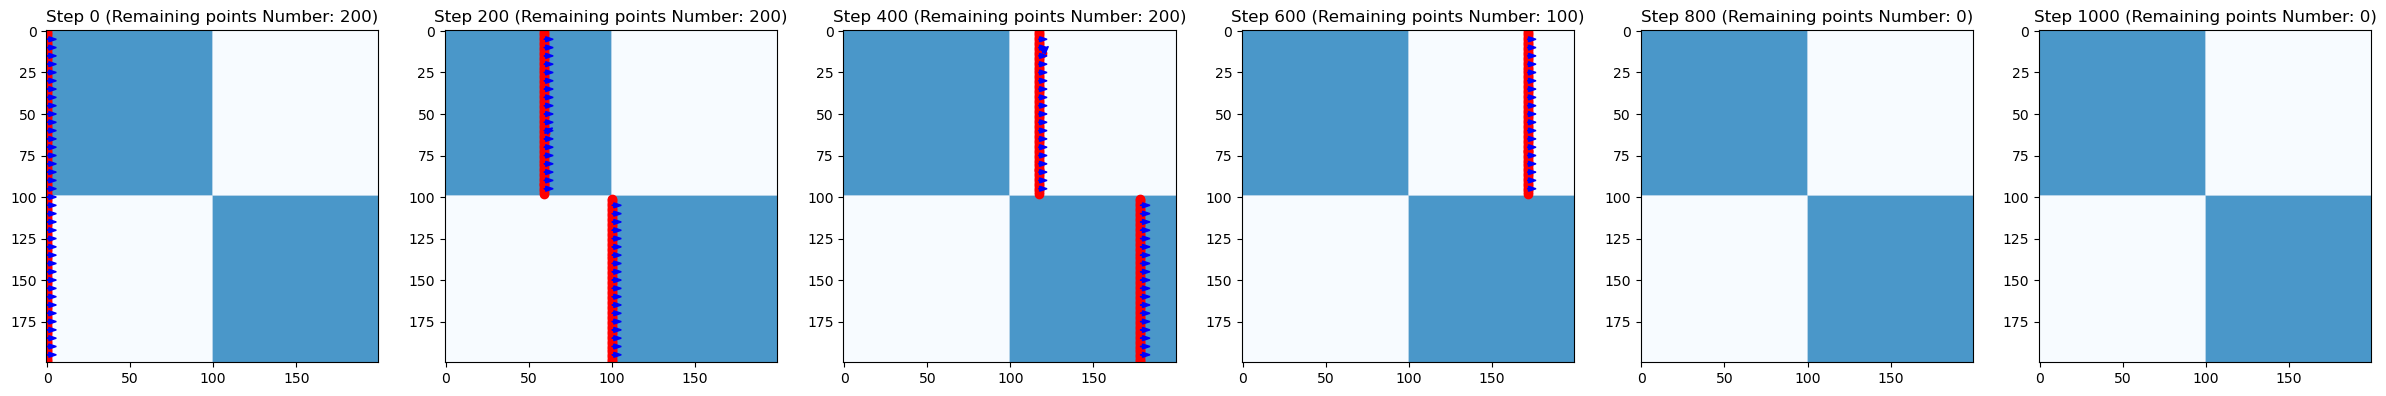

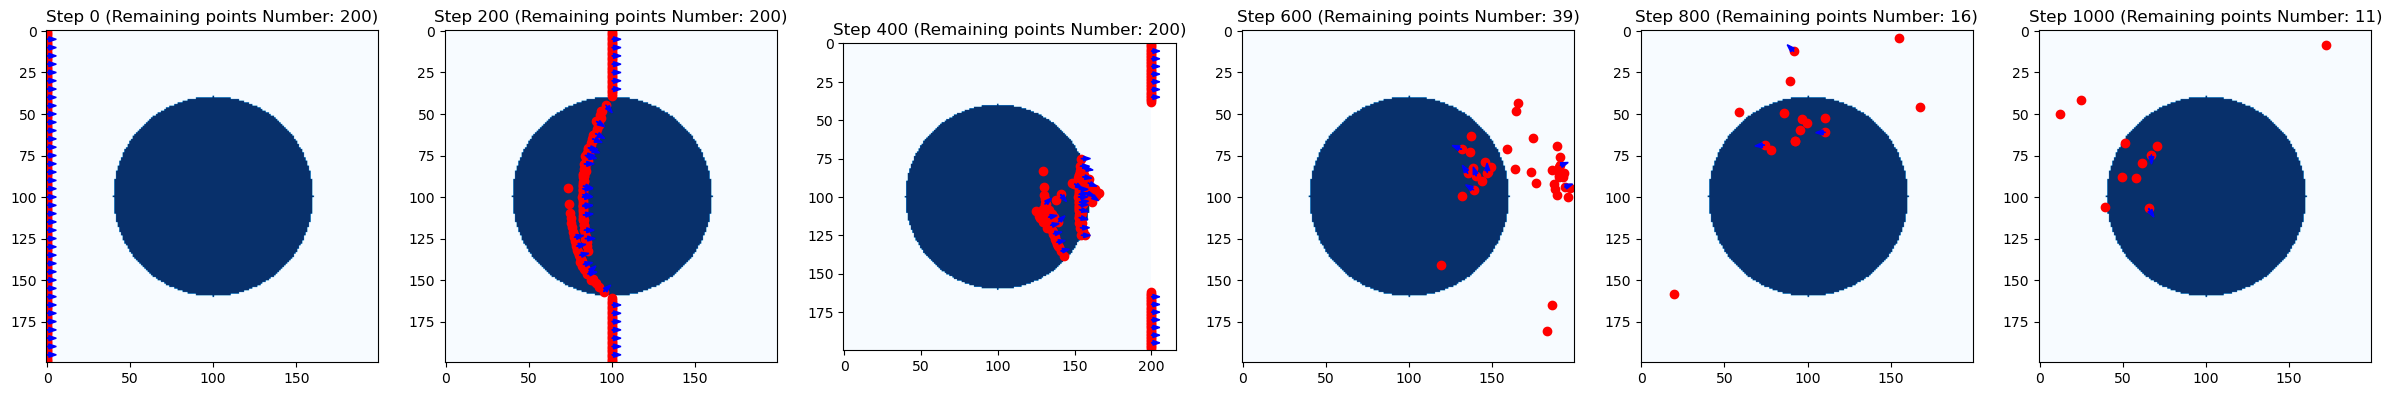

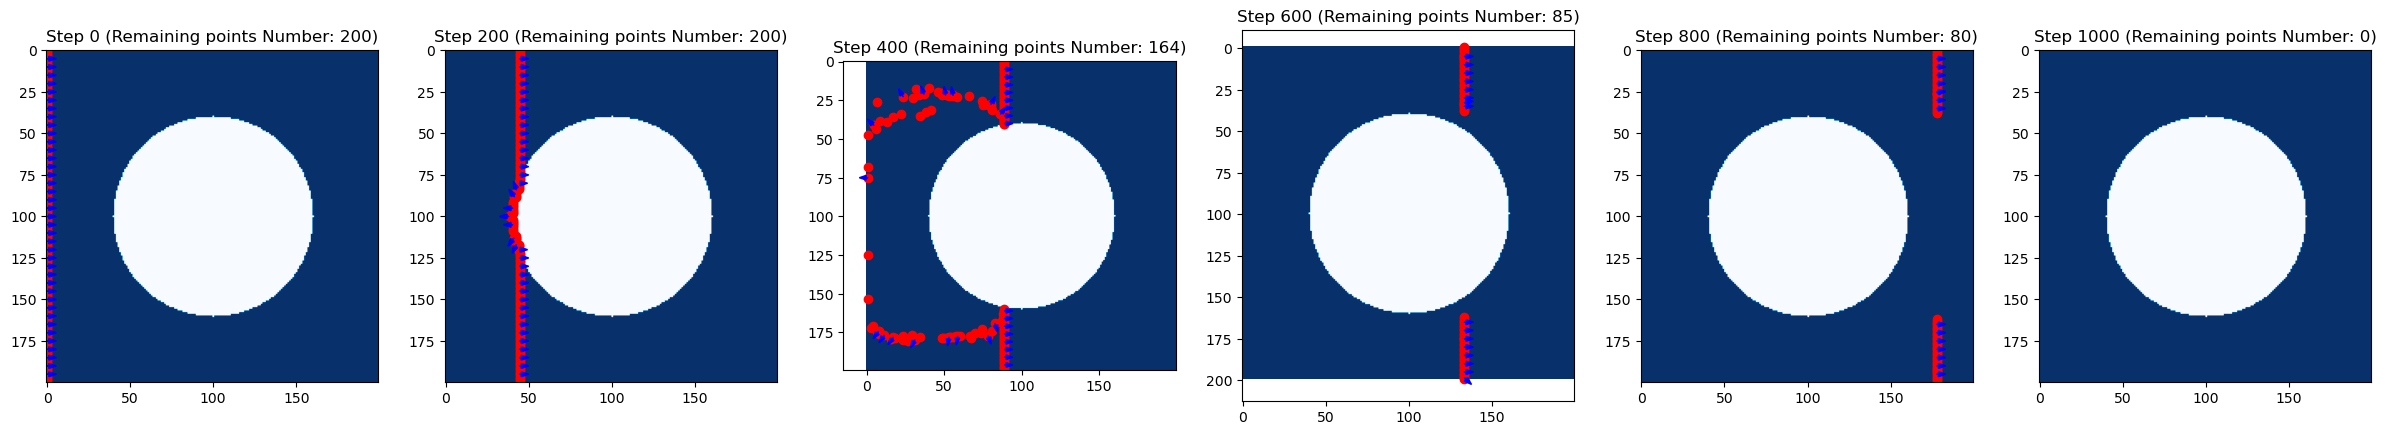

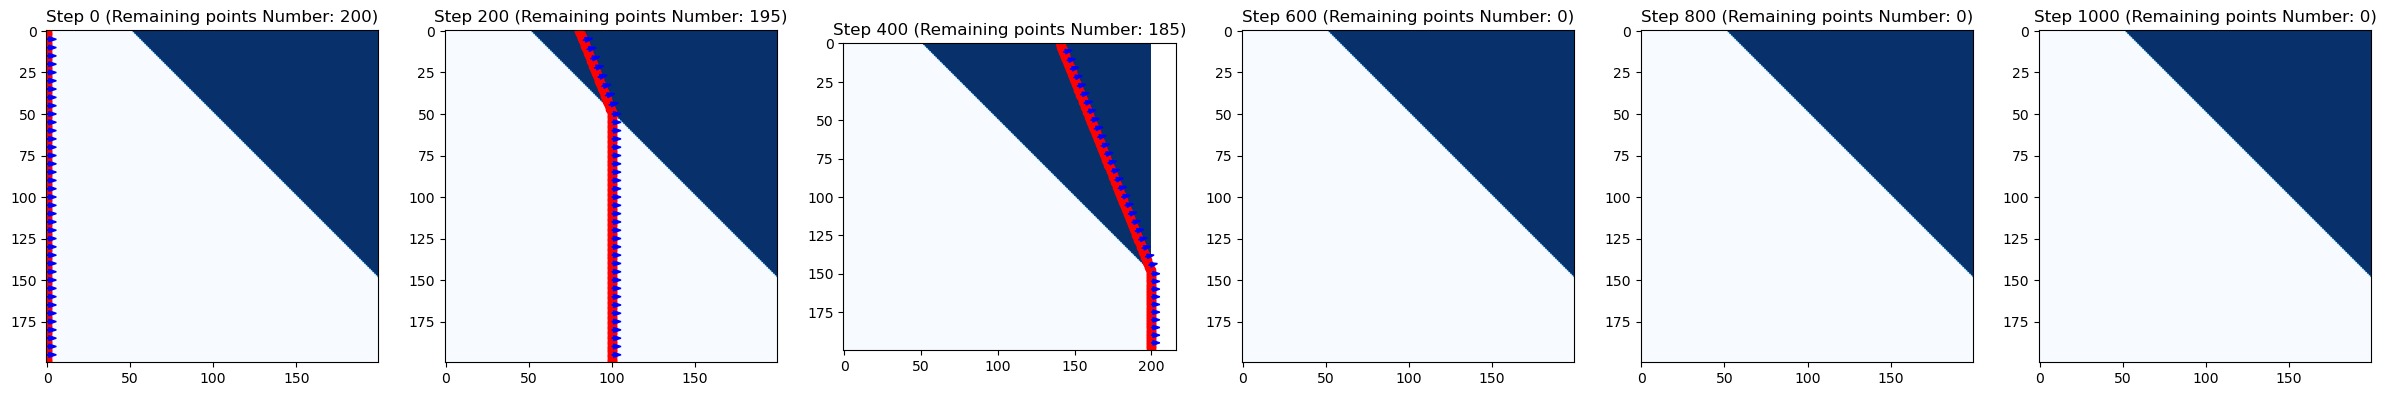

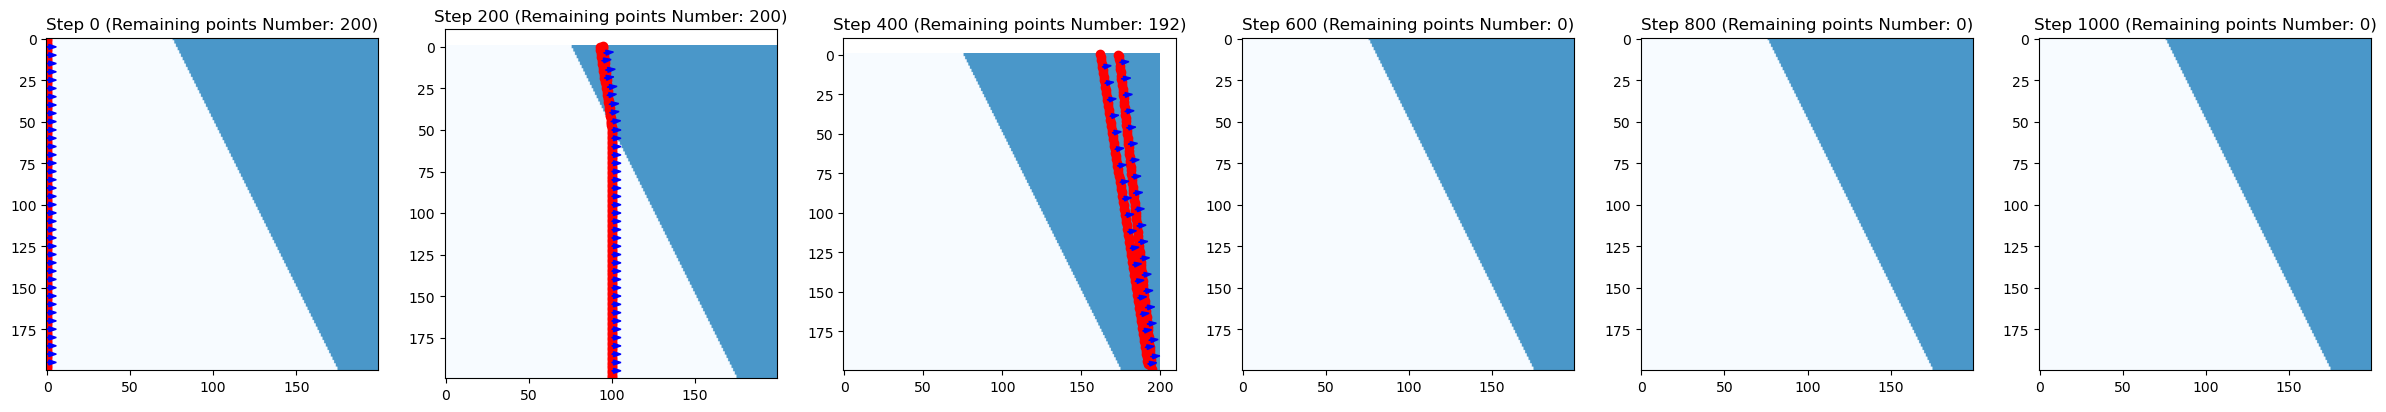

In [46]:
def update_wavefront(pos, dir, IOR, delta_t):
    new_pos = []
    new_dir = []
    grad_x_ior, grad_y_ior = compute_gradients(IOR)
    for (x, y), (vx, vy) in zip(pos, dir):
        if 0 <= int(y) < IOR.shape[0] and 0 <= int(x) < IOR.shape[1]:
            n = IOR[int(y), int(x)]
            
            # x_i+1 = x_i + delta_t * v_i / n^2
            # v_i+1 = v_i + delta_t * grad_n / n
            # calculate the new position
            new_x = x + delta_t * (vx / (n**2))
            new_y = y + delta_t * (vy / (n**2))

            # calculate the new direction
            nx = grad_x_ior[int(y), int(x)]
            ny = grad_y_ior[int(y), int(x)]
            new_vx = vx + delta_t * (nx / n)
            new_vy = vy + delta_t * (ny / n)

            new_pos.append((new_x, new_y))
            new_dir.append((new_vx, new_vy))

        else:
            pass

    return new_pos, new_dir

def simulate_wavefront_propagation(cur_IOR, inital_wavefront_pos, initial_wavefront_dir, num_steps=200, delta_t=1.0):
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], cur_IOR, delta_t)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)
    return wavefront_pos_list, wavefront_dir_list

def visualize_wavefront_propagation(wavefront_pos_list, wavefront_dir_list, cur_IOR, num_show_images=5):
    # show the wavefront propagation in num_show_images steps between 0 and num_steps
    num_show_images = [i for i in range(0, num_steps + 1, num_steps // num_show_images)]

    plt.figure(figsize=(5 * len(num_show_images), 5))
    for i in num_show_images:
        plt.subplot(1, len(num_show_images), num_show_images.index(i) + 1)
        plt.imshow(cur_IOR, cmap='Blues', vmin=1.0, vmax=1.5)
        plt.scatter([p[0] for p in wavefront_pos_list[i]], [p[1] for p in wavefront_pos_list[i]], color='red')
        for j, (x, y) in enumerate(wavefront_pos_list[i]):
            if j != 0 and j % 5 == 0:
                plt.arrow(x, y, wavefront_dir_list[i][j][0], wavefront_dir_list[i][j][1], color='blue', head_width=3)        
        plt.title(f'Step {i} (Remaining points Number: {len(wavefront_pos_list[i])})')
    plt.show()


for key, value in ior_field_dict.items():
    wavefront_pos_list, wavefront_dir_list = simulate_wavefront_propagation(value['ior'], initial_wavefront_positions, initial_wavefront_directions, num_steps, delta_t)
    value['pos'] = wavefront_pos_list
    value['dir'] = wavefront_dir_list
    visualize_wavefront_propagation(wavefront_pos_list, wavefront_dir_list, value['ior'], num_show_images)

## 3. Calculate irradiance

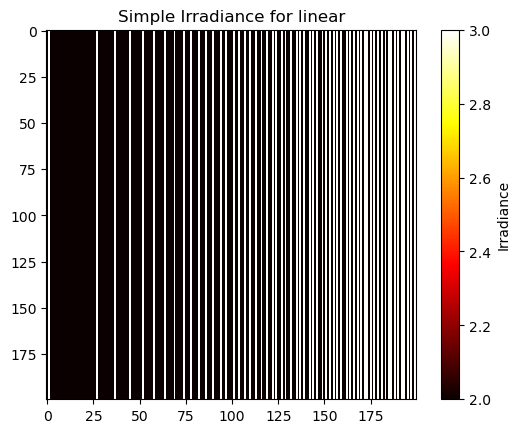

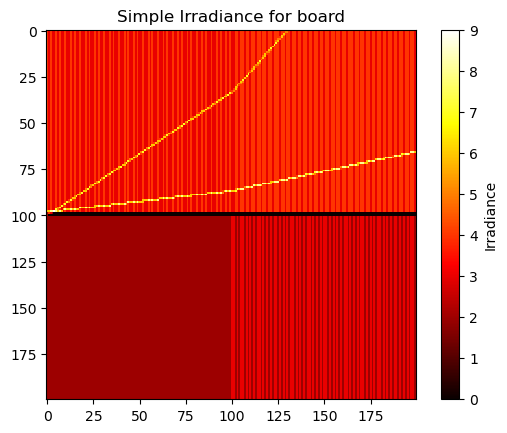

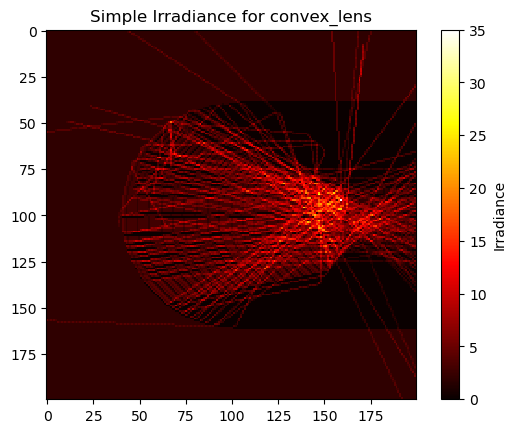

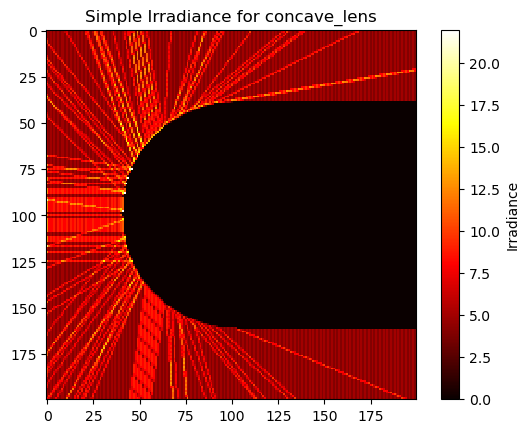

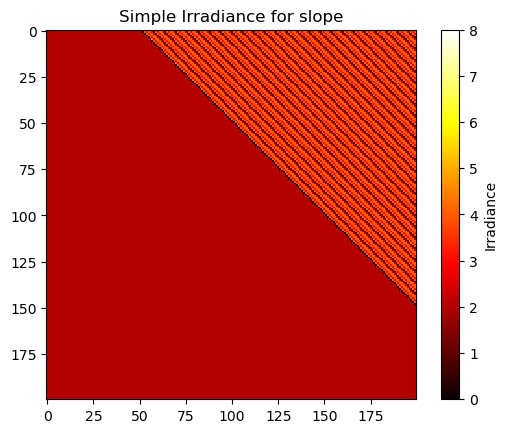

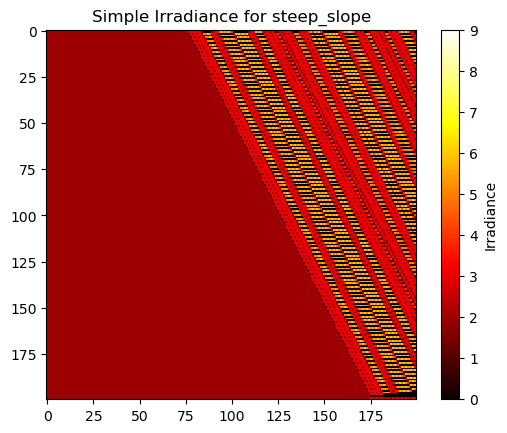

In [47]:
def compute_simple_irradiance(wavefront_pos_list, field_size):
    irradiance = np.zeros((field_size, field_size))

    for pos_list in wavefront_pos_list:
        for x, y in pos_list:
            if 0 <= int(y) < field_size and 0 <= int(x) < field_size:
                irradiance[int(y), int(x)] += 1

    return irradiance

def visualize_irradiance(irradiance, title):
    plt.figure()
    plt.imshow(irradiance, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Irradiance')
    plt.title(title)
    plt.show()

for key, value in ior_field_dict.items():
    irradiance = compute_simple_irradiance(value['pos'], field_size)
    visualize_irradiance(irradiance, f'Simple Irradiance for {key}')

## 4. Store irradiance into quad tree

In [48]:
class Node:
    def __init__(self, val: int, isLeaf, topLeft=None, topRight=None, bottomLeft=None, bottomRight=None):
        self.val = val
        self.isLeaf = isLeaf
        self.topLeft = topLeft
        self.topRight = topRight
        self.bottomLeft = bottomLeft
        self.bottomRight = bottomRight


class QuadTree:
    def construct(self, grid: List[List[int]]) -> Node:
        return self.helper(grid, 0, 0, len(grid))


    def helper(self, grid: List[List[int]], i, j, w) -> Node:
        if self.allSame(grid, i, j, w):
            return Node(grid[i][j] == 1, True)

        node = Node(1, False)
        node.topLeft = self.helper(grid, i, j, w // 2)
        node.topRight = self.helper(grid, i, j + w // 2, w // 2)
        node.bottomLeft = self.helper(grid, i + w // 2, j, w // 2)
        node.bottomRight = self.helper(grid, i + w // 2, j + w // 2, w // 2)
        return node
    

    def allSame(self, grid, i, j, w):
        for x in range(i, i + w):
            for y in range(j, j + w):
                if grid[x][y] != grid[i][j]:
                    return False
        return True